In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy import stats

import database_queries.database_query as dq

from database_session.database_session import GetDatabaseSession

## Get Data

In [3]:
DATABASE_PATH = "../database/hockey_v16_test.db"
QUERY_FILE_PATH = (
    "C://Users//jziac//OneDrive//Documents//programovani//"
    "projekty//elite//data//other//queries.json"
)

In [4]:
db_session = GetDatabaseSession(db_path=DATABASE_PATH)
db_session.set_up_connection()
query_o = dq.DbDataGetter(db_session=db_session.session)
data_players = query_o.get_db_query_result(
    query_name="season_player_stats", query_file_path=QUERY_FILE_PATH
    )
data_goalies = query_o.get_db_query_result(
    query_name="season_goalie_stats", query_file_path=QUERY_FILE_PATH
    )
data_drafts = query_o.get_db_query_result(
    query_name="draft_data_simple", query_file_path=QUERY_FILE_PATH
    )
data_nationalities = query_o.get_db_query_result(
    query_name="nationalities", query_file_path=QUERY_FILE_PATH
    )

INFO: New scrapping session started
INFO: New DB session initiated with db at ../database/hockey_v16_test.db


## Data Processing

In [5]:
players = pd.DataFrame(
    data_players, columns=[
    'player_id', 'player_name', 'position', 'regular_season', 'team_id', 'team_name', 'season', 'games_played', 'g', 'a', 'tp', 'plus_minus', 'league'
    ]
    )

goalies = pd.DataFrame(
    data_goalies, columns=[
    'player_id', 'player_name', 'position', 'regular_season', 'team_id', 'team_name', 'season', 'games_played', 'gd', 'gaa', 'svp', 'ga', 'svs', 'so', 'w', 'l', 't', 'toi', 'league'
    ]
)

drafts = pd.DataFrame(
    data_drafts, columns=[
    'player_id', 'player_name', 'position', 'draft_team',
    'draft_position', 'draft_round', 'draft_year', 'team_id'
    ]
    )

nationalities = pd.DataFrame(
    data_nationalities, columns=['player_id', 'nationality']
    )

# delete duplicated rows given joins (players drafted twice etc.)
players = players.drop_duplicates(
    subset=[
        'player_id', 'player_name', 'league', 'regular_season', 'team_id', 'team_name', 'season'
        ]
    )

goalies = goalies.drop_duplicates(
    subset=[
        'player_id', 'player_name', 'position', 'league', 'regular_season', 'team_id', 'team_name', 'season'
        ]
    )


## Data Overview

In [23]:
drafts[['draft_year', 'player_id']].groupby(['draft_year']).nunique().head(60)

,player_id
draft_year,
1963,21
1964,24
1965,11
1966,24
1967,18
1968,24
1969,84
1970,115
1971,117


## Preprocess Data

In [5]:
#sum games in case player plays for more teams in one season
player_stats = df.groupby(['player_id', 'player_name', 'season', 'league'], as_index=False)[["games_played","g", "a", "tp", "plus_minus"]].sum()
draft_info = df[['player_id', 'player_name', 'draft_position', 'draft_round', 'draft_year']].drop_duplicates()
player_stats = pd.merge(player_stats, draft_info, on='player_id')
player_stats.sort_values(by='tp', ascending=False)

player_stats_overall_nhl = df[df['league']=='nhl'].groupby(['player_id', 'player_name'], as_index=False)[["games_played","g", "a", "tp", "plus_minus"]].sum()
player_stats_overall_nhl = pd.merge(player_stats_overall_nhl, draft_info[["draft_position", "draft_round", "draft_year", "player_id"]], on='player_id')

In [76]:
draft_info[draft_info['draft_year'] == 1975]

,player_id,player_name,draft_position,draft_round,draft_year
206888,34109,John Tweedle,39,3,1975
206896,34110,Joe Fortunato,47,3,1975
206904,34111,Clark Hamilton,50,3,1975
206926,34112,Dale Ross,62,4,1975
206932,34115,Denis Daigle,68,4,1975
...,...,...,...,...,...
207340,34180,Tom Funke,212,15,1975
207350,34181,Bob Shaw,213,15,1975
207356,34182,Don Madson,214,15,1975
207369,34183,Bob Bain,215,16,1975


In [6]:
active_players = df.loc[df['season']=='2023-2024', 'player_id'].to_list()
non_active_players = list(set(df['player_id'].to_list()) - set(active_players))

## Analysis

### Number of Rounds by Year

INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


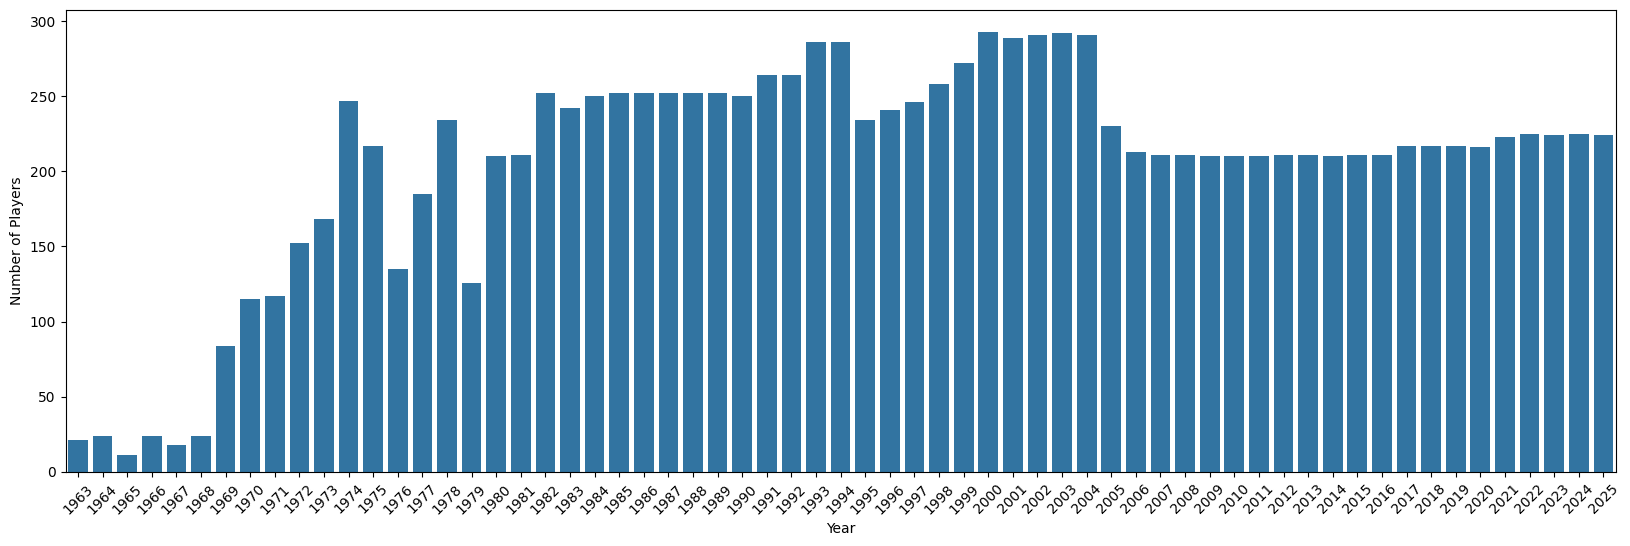

In [30]:
plt.figure(figsize=(20, 6)) 
sns.barplot(
    drafts[['draft_year', 'player_id']].groupby('draft_year').nunique().reset_index(), 
    x="draft_year", y="player_id"
    )
plt.xticks(rotation=45) 
plt.xlabel("Year")
plt.ylabel("Number of Players")
plt.show()

### Players Drafted by their Nationality through Years

In [105]:
COLOR_MAP = {
    'Canada': '#d62728',       # Bright Red
    'Russia': '#1f77b4',       # Blue
    'Sweden': '#ffdd00',       # Bright Yellow
    'Finland': '#2ca02c',      # Green
    'Czechia': '#9467bd', # Purple
    'USA': '#17becf',          # Cyan
    'Slovakia': '#e377c2',     # Pink
    'Germany': '#000000',      # Black
    'Switzerland': '#ff7f0e',   # Orange
    'Other': '#bbbbbb'
}

OTHER_COUNTRY = [
    'Austria', 'Slovenia', 'Belarus',  'Denmark',
    'Kazakhstan', 'Lithuania', 'China', 'Ukraine', 
    'Latvia', 'Norway', 'Croatia', 'Netherlands', 'Italy', 'Australia',
    'France', 'Poland', 'New Zealand', 'Hungary', 'Scotland', 'Japan',
    'Spain', 'England', 'Israel', 'Estonia', 'Romania', 'Serbia', 'U.K.', 'South Korea', 'Germany', 'Switzerland', 'Slovakia'
    ]

In [106]:
drafts_copy = drafts.copy()
#add nationalities - only first 1 in case there are two, should be the more #'relevant' nationality
drafts_copy = pd.merge(drafts_copy, nationalities, on="player_id").drop_duplicates(subset=["player_id"])
#transform less common countries to other country group
drafts_copy['nationality'] = drafts_copy['nationality'].replace(
    OTHER_COUNTRY, "Other"
    )
#calculate overall counts for each country
nationality_overall = drafts_copy.groupby(['nationality']).size()
nationality_overall = nationality_overall.sort_values(ascending=False)

yearly_country_round_counts = drafts_copy.value_counts(
    subset=["draft_year", "draft_round", "nationality"]
    ).reset_index()

yearly_country_counts = drafts_copy.drop_duplicates(subset=["draft_year", "player_id"]).value_counts(subset=["draft_year", "nationality"]).reset_index()

yearly_counts = drafts_copy.drop_duplicates(subset=["draft_year", "player_id"]).groupby(["draft_year"]).size().reset_index(name="count")

yearly_round_counts = (
    drafts_copy.groupby(["draft_year", "draft_round"])
    .size().reset_index(name="count")
    )

In [107]:
shares = pd.merge(
    yearly_country_counts.reset_index(), 
    yearly_counts, 
    on=["draft_year"], 
    how="left"
    )
shares["share"] = shares["count_x"] /shares["count_y"]
shares['nat_freq'] = shares['nationality'].map(nationality_overall)
shares = shares.sort_values(by='nat_freq', ascending=False)
shares = shares.drop(columns='nat_freq')

shares = shares.drop(columns=['count_x', 'count_y'])


#### Overall Number of Drafted Players by their Nationality

<Axes: xlabel='nationality'>

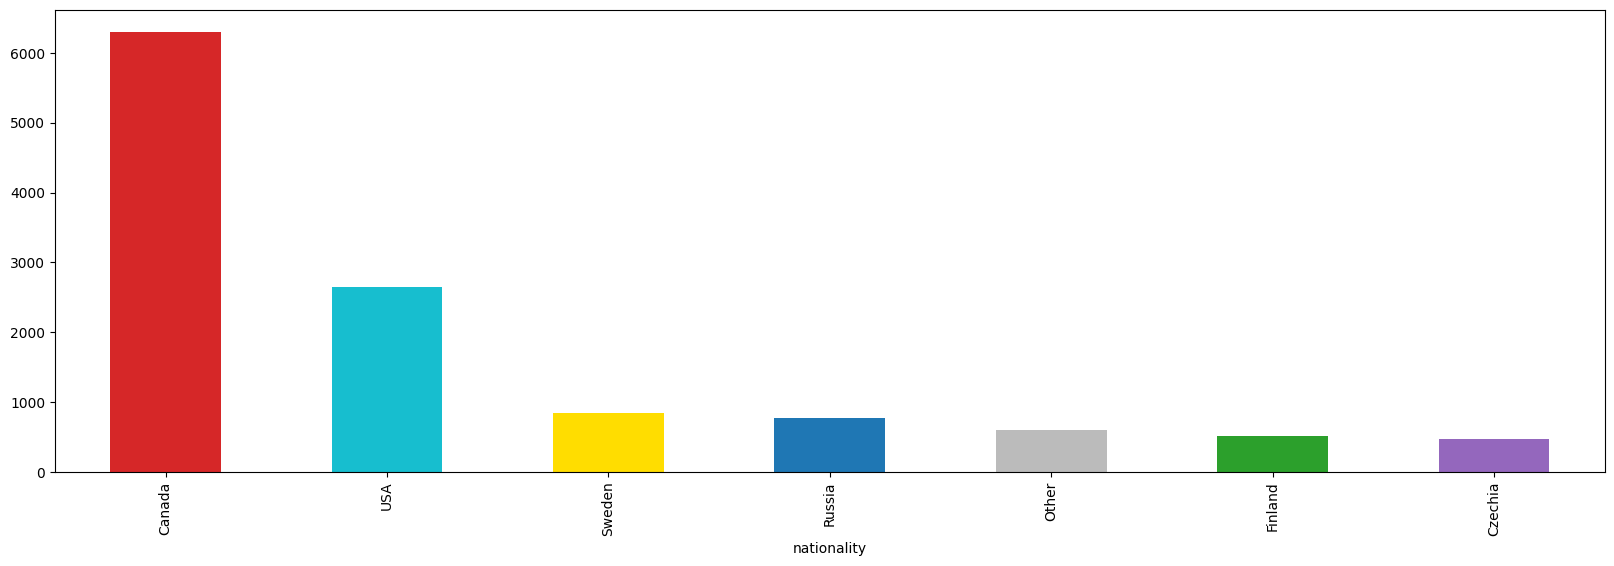

In [108]:
nationality_overall.plot(kind='bar', stacked=True, figsize=(20, 6), color=[COLOR_MAP[col] for col in nationality_overall.index])

#### Shares of Nationalities in Individual Drafts

<Axes: xlabel='draft_year'>

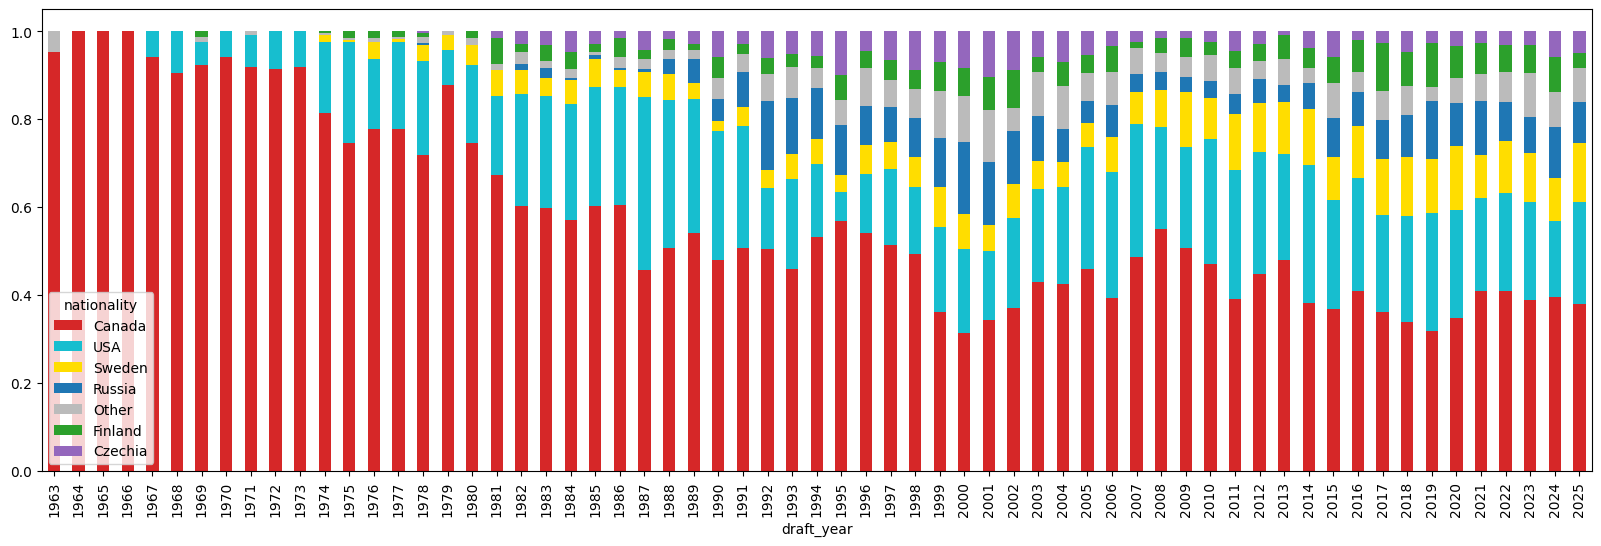

In [109]:
shares.set_index(['draft_year', 'nationality'])['share'].unstack(fill_value=0)[nationality_overall.index].plot(kind='bar', stacked=True, figsize=(20, 6), color=[COLOR_MAP[col] for col in shares['nationality'].unique()])

#### Shares - Last 10 Years 

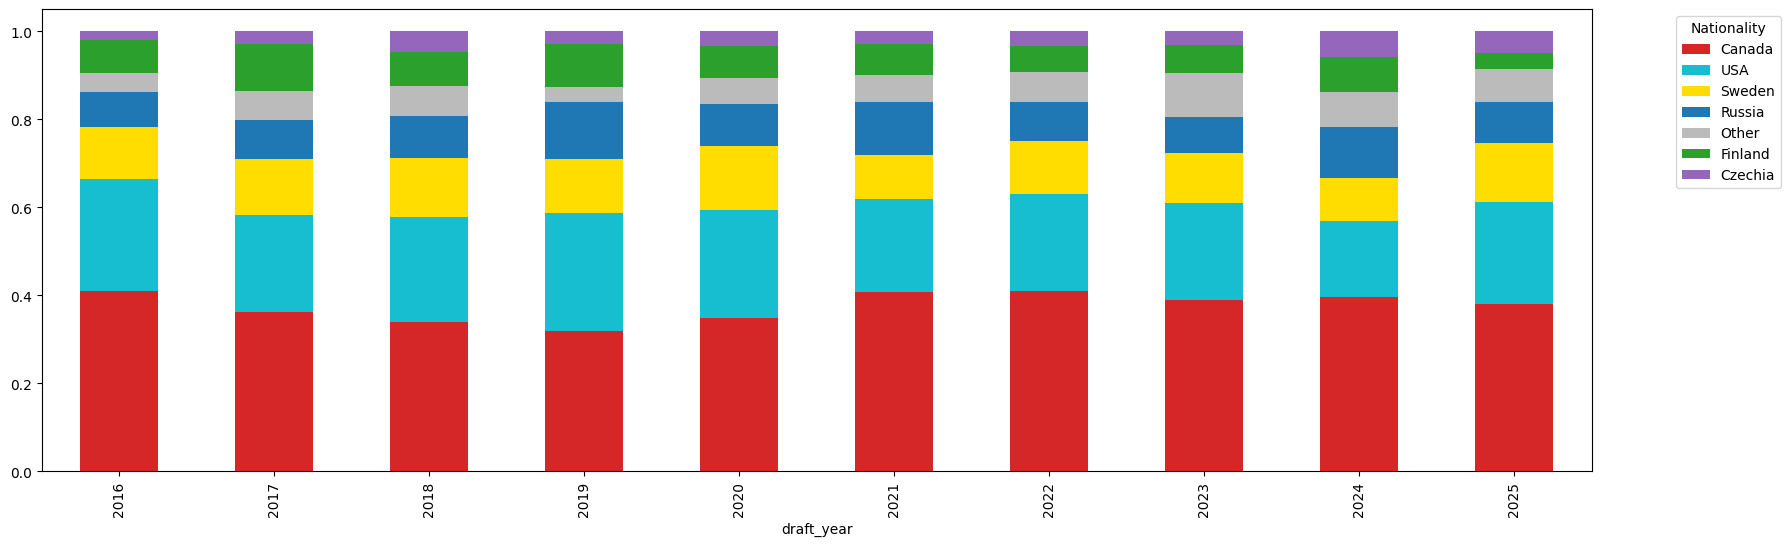

In [ ]:
shares[shares["draft_year"] > 2015].set_index(['draft_year', 'nationality'])['share'].unstack(fill_value=0)[nationality_overall.index].plot(
    kind='bar', stacked=True, figsize=(20, 6), 
    color=[COLOR_MAP[col] for col in shares['nationality'].unique()]
    )
plt.legend(title="Nationality", bbox_to_anchor=(1.05, 1), loc='upper left')

#### Shares - 1. Round Picks

In [112]:
shares_round = pd.merge(
    yearly_country_round_counts, 
    yearly_round_counts, 
    on=["draft_year", "draft_round"], 
    how="left"
    )
shares_round["share"] = shares_round["count_x"] / shares_round["count_y"]

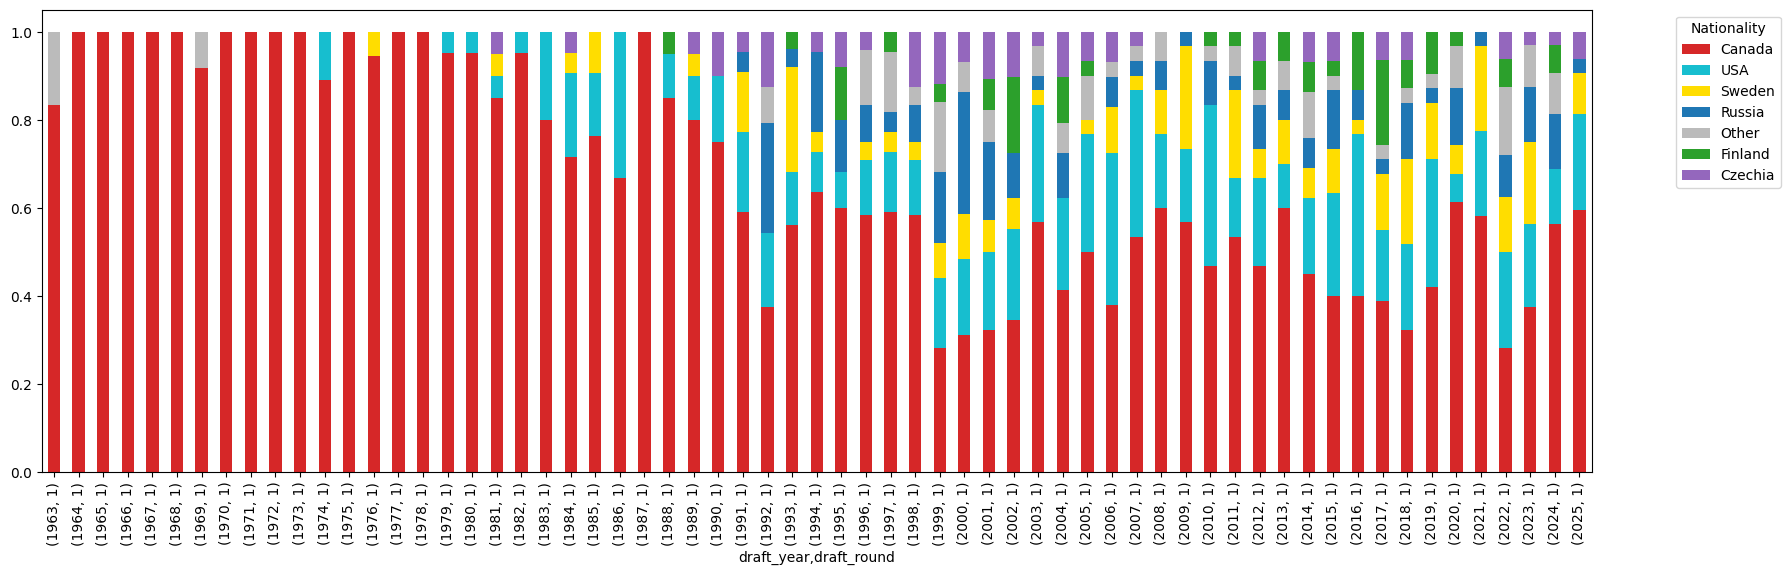

In [117]:
shares_round[shares_round["draft_round"] == 1].set_index([
    'draft_year', 'draft_round', 'nationality'
    ])['share'].unstack(fill_value=0)[nationality_overall.index].plot(
        kind='bar', stacked=True, figsize=(20, 6), color=[COLOR_MAP[col] for col in shares['nationality'].unique()]
        )
plt.legend(title="Nationality", bbox_to_anchor=(1.05, 1), loc='upper left')

#### Distribution of Picks in the Last 10 Years - Czech Republic

<Axes: xlabel='draft_round'>

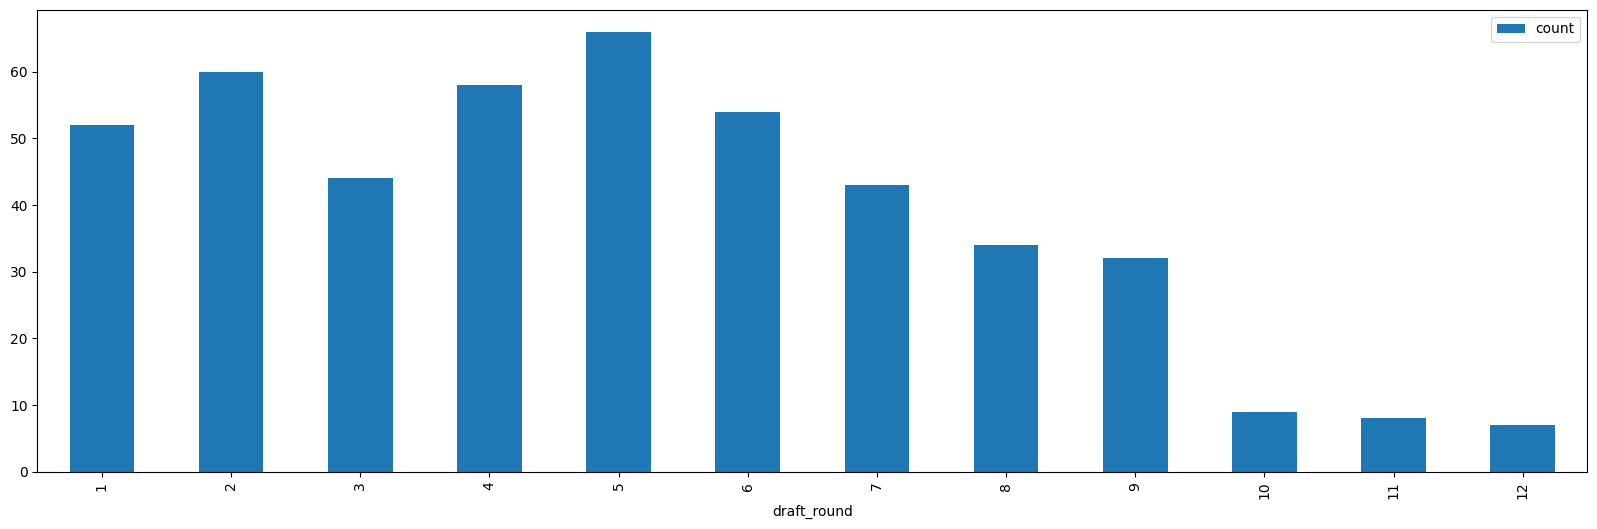

In [102]:
yearly_country_round_counts[
    yearly_country_round_counts['nationality'] == 'Czechia'
].groupby('draft_round')['count'].sum().reset_index(name="count").plot(x='draft_round', y='count', kind='bar', figsize=(20, 6))

#### Average Age 100 matches achived

In [35]:
players.sort_values(["player_id", "season"]).loc[players["league"] == "nhl", "sum_gp"]  = players.sort_values(["player_id", "season"])[players["league"] == "nhl"].groupby(["player_id"])["games_played"].cumsum()

C:\Users\jziac\AppData\Local\Temp\ipykernel_19428\96741377.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  players.sort_values(["player_id", "season"]).loc[players["league"] == "nhl", "sum_gp"]  = players.sort_values(["player_id", "season"])[players["league"] == "nhl"].groupby(["player_id"])["games_played"].cumsum()
C:\Users\jziac\AppData\Local\Temp\ipykernel_19428\96741377.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform t

In [36]:
players[(players['league']=='nhl') & (players['player_name']=='Sidney Crosby')]

,player_id,player_name,position,regular_season,team_id,team_name,season,games_played,g,a,tp,plus_minus,league,sum_gp
256252,5868,Sidney Crosby,C,False,81,Pittsburgh Penguins,2005-2006,NaN,NaN,NaN,NaN,NaN,nhl,NaN
256253,5868,Sidney Crosby,C,True,81,Pittsburgh Penguins,2005-2006,81.0,39.0,63.0,102.0,-1.0,nhl,81.0
256256,5868,Sidney Crosby,C,False,81,Pittsburgh Penguins,2006-2007,5.0,3.0,2.0,5.0,0.0,nhl,5.0
256257,5868,Sidney Crosby,C,True,81,Pittsburgh Penguins,2006-2007,79.0,36.0,84.0,120.0,10.0,nhl,84.0
256258,5868,Sidney Crosby,C,False,81,Pittsburgh Penguins,2007-2008,20.0,6.0,21.0,27.0,7.0,nhl,20.0
256259,5868,Sidney Crosby,C,True,81,Pittsburgh Penguins,2007-2008,53.0,24.0,48.0,72.0,18.0,nhl,73.0
256260,5868,Sidney Crosby,C,False,81,Pittsburgh Penguins,2008-2009,24.0,15.0,16.0,31.0,9.0,nhl,24.0
256261,5868,Sidney Crosby,C,True,81,Pittsburgh Penguins,2008-2009,77.0,33.0,70.0,103.0,3.0,nhl,101.0
256262,5868,Sidney Crosby,C,False,81,Pittsburgh Penguins,2009-2010,13.0,6.0,13.0,19.0,6.0,nhl,13.0
256263,5868,Sidney Crosby,C,True,81,Pittsburgh Penguins,2009-2010,81.0,51.0,58.0,109.0,15.0,nhl,94.0


In [25]:
players.loc[players["league"] == "nhl", ['player_id', 'season', 'sum_gp']].sort_values(by=["player_id", "season", "sum_gp"])

,player_id,season,sum_gp
27,1,2005-2006,1.0
26,1,2005-2006,NaN
31,1,2006-2007,1.0
30,1,2006-2007,NaN
63,2,2005-2006,1.0
...,...,...,...
1226744,31347,2024-2025,10.0
1226770,31348,2024-2025,4.0
1226771,31348,2024-2025,NaN
1226774,31348,2025-2026,NaN


In [1]:
shares["share percent"] = shares["share"].round(4) * 100
shares[shares["draft_year"] > 2015].set_index(['draft_year', 'nationality'])['share percent'].unstack(fill_value=0)

NameError: name 'shares' is not defined

#### Counts

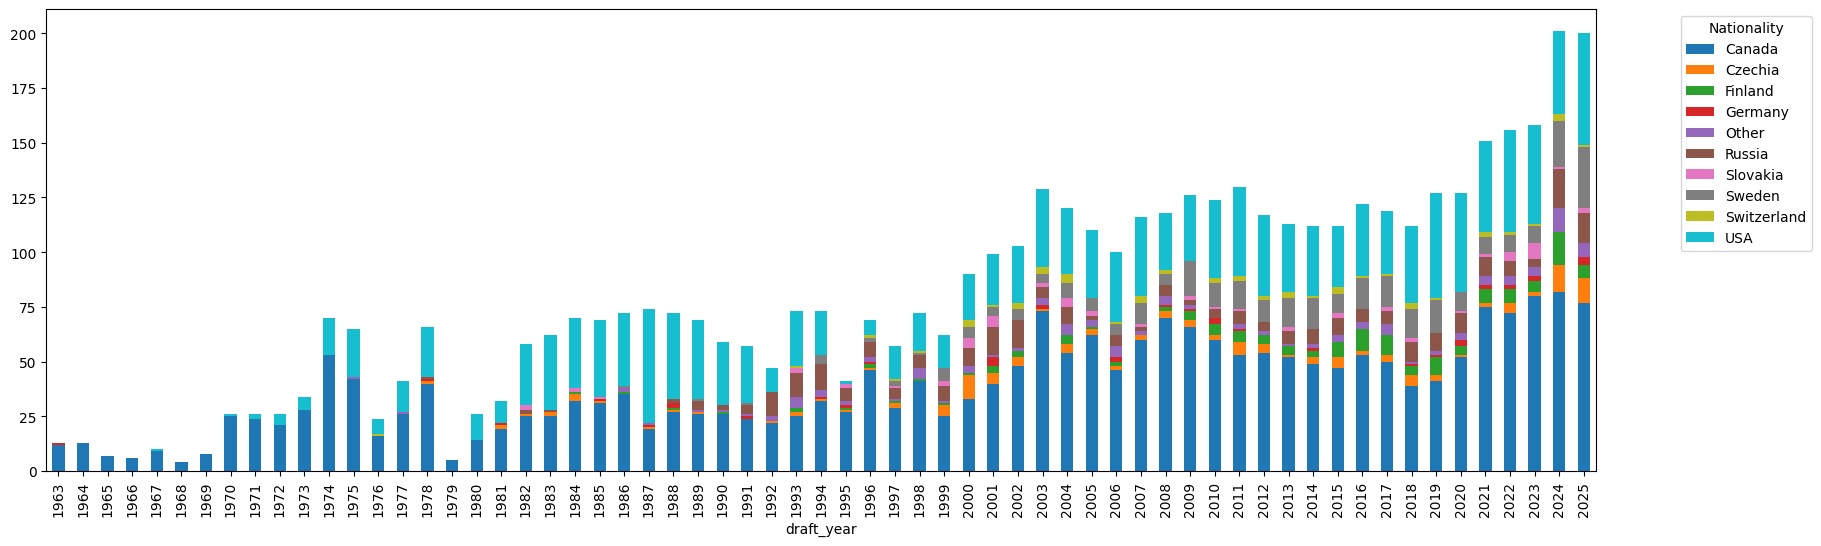

In [12]:
yearly_country_counts.unstack(fill_value=0).plot(kind='bar', stacked=True, figsize=(20, 6))
plt.legend(title="Nationality", bbox_to_anchor=(1.05, 1), loc='upper left')

### All Time Best Value Picks

In [87]:
player_stats_overall_nhl.keys()

Index(['player_id', 'player_name', 'games_played', 'g', 'a', 'tp',
       'plus_minus', 'draft_position', 'draft_round', 'draft_year'],
      dtype='object')

In [93]:
player_stats_overall_nhl[player_stats_overall_nhl["draft_round"] > 5].sort_values(by="tp", ascending=False).head(15)

,player_id,player_name,games_played,g,a,tp,plus_minus,draft_position,draft_round,draft_year
34,4641,Daniel Alfredsson,1433.0,517.0,803.0,1320.0,166.0,133,6,1994
381,6084,Joe Pavelski,1533.0,550.0,661.0,1211.0,200.0,205,7,2003
185,5572,Henrik Zetterberg,1219.0,394.0,686.0,1080.0,201.0,210,7,1999
160,5441,Pavel Datsyuk,1110.0,356.0,675.0,1031.0,283.0,171,6,1998
40,4675,Steve Sullivan,1141.0,321.0,514.0,835.0,102.0,233,9,1994
41,4681,Andrew Brunette,1239.0,308.0,510.0,818.0,-128.0,174,7,1993
868,6924,Mark Stone,818.0,272.0,447.0,719.0,149.0,178,6,2010
54,4809,Tomas Holmström,1289.0,305.0,361.0,666.0,68.0,257,10,1994
162,5443,Radim Vrbata,1099.0,292.0,349.0,641.0,-36.0,212,7,1999
88,5034,Kimmo Timonen,1264.0,129.0,510.0,639.0,35.0,250,10,1993


### Average Career Matches Played Based Round Drafted

In [78]:
player_stats_overall
draft_mean_games = player_stats_overall[filter_draft].groupby("draft_round").agg(
    games_played=("games_played", "median")).reset_index()
sns.barplot(draft_mean_games, x="draft_round", y="games_played")

NameError: name 'player_stats_overall' is not defined

## Does Difference between Rounds Drafted with exception of First Round matter?

## Average Career Matches Played Based on Position Drafted

In [1]:
draft_mean_games = player_stats_overall[(filter_draft)&(player_stats_overall['draft_position'] <=32)].groupby("draft_position").agg(
    games_played=("games_played", "median")).reset_index()
sns.barplot(draft_mean_games, x="draft_position", y="games_played")

NameError: name 'player_stats_overall' is not defined